## General information about this notebook

This notebook series has been initiated by the Data Management Project (INF) within the TR-172 ["ArctiC Amplification: Climate Relevant Atmospheric and SurfaCe Processes, and Feedback Mechanisms" (AC)³](http://www.ac3-tr.de/) funded by the German Research Foundation (Deutsche Forschungsgemeinschaft, DFG)

Author(s) of this notebook: 
 - Jonas Hachmeister, [Institute of Environmental Physics, University Bremen](https://www.iup.uni-bremen.de/deu/), Otto-Hahn-Allee 1 - 28359 Bremen, jonas_h@iup.physik.uni-bremen.de

Github repository: https://github.com/ac3-tr/ac3-notebooks

This notebook is licensed under the [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/ "CC-BY-4.0")

# Dataset description

**Title:** Ny-Ålesund FTIR CH$_4$ measurements

**Authors** Prof. Dr. Justus Notholt, Mathias Palm (IUP, Bremen)

**Description** Solar and lunar (during polar night) observations of atmospheric trace gases. Here for methane. Instrument: Bruker IFS 120-5 HR. Detailled information can be found [here](https://www-air.larc.nasa.gov/pub/NDACC/PUBLIC/meta/ftir/NyAlesund_ftir_jn_2021.pdf).

**Year** 2021       

**Institutes** Insitute of Environmental Physics, University of Bremen

**DOI** /        

**License**    [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/ "CC-BY-4.0")

## Contents of this notebook

This notebook provides a minimal working example of reading and plotting the NDACC FTIR data from the Ny-Ålesund site. The files are provided in the *.hdf* format.
This code should also work with data from other NDACC sites and should be easily adaptable to other atmospheric species.

## Import relevant modules
The following packages are needed to execute this jupyter notebook: *numpy, matplotlib and pyhdf*. The packages will be automatically installed using the pip command when executing the next cell.

In [1]:
!pip install numpy pyhdf matplotlib

In [1]:
import datetime as dt 

import numpy as np
import matplotlib.pyplot as plt
from pyhdf import SD

## Pre-processing of the imported data

The data can be automatically downloaded by executing the following cell (size: ~2 mb)

In [2]:
!wget -q "https://www-air.larc.nasa.gov/cgi-bin/ndaccPub?stations/ny.alesund/hdf/ftir/groundbased_ftir.ch4_awi001_ny.alesund_20210317t090037z_20210913t090623z_009.hdf" -O "groundbased_ftir.ch4_awi001_ny.alesund_20210317t090037z_20210913t090623z_009.hdf"

In [3]:
path = "./groundbased_ftir.ch4_awi001_ny.alesund_20210317t090037z_20210913t090623z_009.hdf"

NDACC times use 1.1.2000 as a reference time. We convert the times to use 1.1.1970 as a reference to make them easily plottable by matplotlib.

In [4]:
T_SHIFT = (dt.datetime(2000,1,1,0,0)-dt.datetime(1970,1,1,0,0)).days + (dt.datetime(2000,1,1,0,0)-dt.datetime(1970,1,1,0,0)).seconds/24/60/60

Next we load the *.hdf* file using the SD module of the pyhdf library (see [here](http://fhs.github.io/pyhdf/) for pyhdf documentation)

In [5]:
file = SD.SD(path) 
#print(file.datasets().keys()) # Uncomment to show available variables

Next we load the relevant variables. The time, methane profiles, surface pressure and the pressure levels.

In [6]:
time = file.select("DATETIME").get() + T_SHIFT
ch4 = file.select("CH4.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR").get()
ps = file.select("SURFACE.PRESSURE_INDEPENDENT").get()
p = file.select("PRESSURE_INDEPENDENT").get()

## Plotting example

First we plot the surface pressure as the function of time

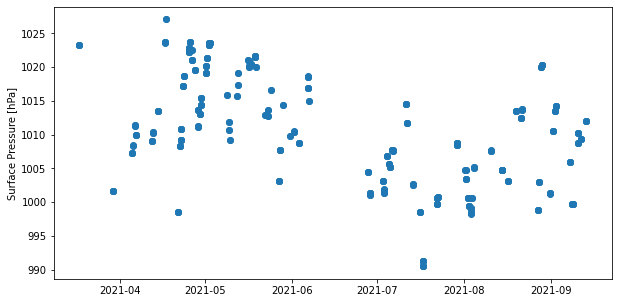

In [7]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(time, ps)
ax.xaxis_date()
ax.set_ylabel("Surface Pressure [hPa]")
plt.show()

We can also plot individual methane profiles:

In [31]:
idx = 175
print(f"Index: {idx}, Date: ",dt.datetime(1970,1,1)+dt.timedelta(days=time[idx]))

Index: 175, Date:  2021-05-24 09:05:24


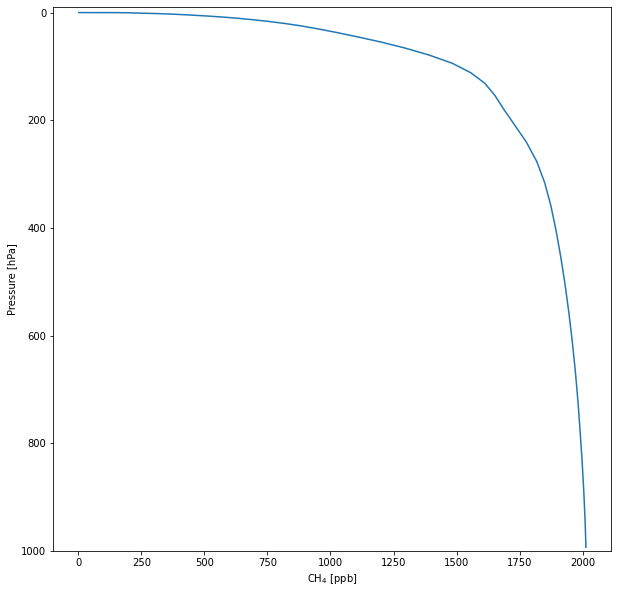

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(ch4[idx]*1000,p[idx])
ax.set_ylim(1000,-10)
ax.set_ylabel("Pressure [hPa]")
ax.set_xlabel("CH$_4$ [ppb]")
plt.show()

Finally we want to calculate a time series of column-averaged methane. For this we first have to calculate the XCH$_4$ using a pressure weighting function (see [here](https://doi.org/10.1029/2006JD008336))

In [33]:
def pressure_weighting_func(pl: np.array, p_surf: float=None) -> np.array:
    """Pressure weighting function, see Connor et al. 2008"""
    if p_surf == None:
        p_surf=pl[0]

    h = np.zeros(pl.shape[0])

    h[0]=np.abs((-pl[0]+(pl[1]-pl[0])/np.log(pl[1]/pl[0])))/(p_surf)
    i=pl.shape[0]-1
    h[i]=np.abs((pl[i]-(pl[i]-pl[i-
                                 1])/np.log(pl[i]/pl[i-1])))/(p_surf)

    for i in range(1,pl.shape[0]-1):
        h[i] = np.abs((-pl[i]+(pl[i+1]-pl[i])/np.log(pl[i+1]/pl[i]))+
        (pl[i]-(pl[i]-pl[i-1])/np.log(pl[i]/pl[i-1]))  )/p_surf

    return h

In [34]:
xch4 = np.zeros(time.shape)
for i in range(0,xch4.shape[0]):
    _pw = pressure_weighting_func(p[i],p_surf=ps[i])
    xch4[i]=np.dot(_pw,ch4[i])

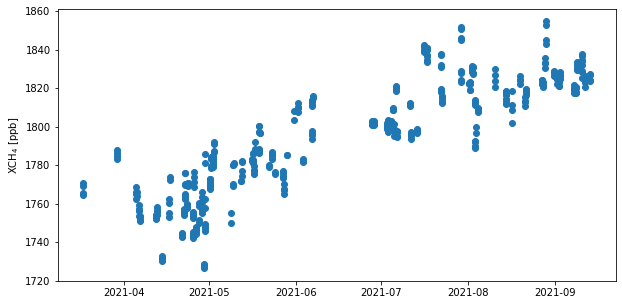

In [35]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(time, xch4*1000)
ax.set_ylabel("XCH$_4$ [ppb]")
ax.xaxis_date()